In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
from posarmctools.readdata import *
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = "/home/pleroy/DATA/PoSAR-MC_PIMA_TEST-3/2017_10_10_13_37_22"

In [4]:
blocksPerFile = 6
samplesPerRamp = 6000
rampsPerFile = 1500
samplesPerFile = samplesPerRamp * rampsPerFile

firstFile = 0
lastFile = 402
#numberOfFiles = int( (lastFile - firstFile) / blocksPerFile + 1 )
numberOfFiles = 20
nbFilesToCheck = numberOfFiles
nbFilesToRebuild = numberOfFiles

threshold = 6000

print( "number of files = {}".format(numberOfFiles) )

number of files = 20


### Read the data

In [5]:
timeSerie_A = np.zeros( samplesPerFile )
timeSerie_B = np.zeros( samplesPerFile )

### Check pulse duration in B channel data

In [ ]:
for k in range(nbFilesToCheck):
    nb = str(int(k * blocksPerFile + firstFile))
    filename = data_dir + "/record" + nb +".bin"
    readFile( filename, samplesPerFile, timeSerie_A, timeSerie_B )
    pulseDuration = np.where(timeSerie_B > threshold)[0].shape[0]
    print("file " + str(nb) + ", pulseDuration =  " + str(pulseDuration))

### Check the triggers in the B channel data

In [ ]:
for k in range(nbFilesToCheck):
    nb = str(int(k * blocksPerFile + firstFile))
    filename = data_dir + "/record" + nb +".bin"
    readFile( filename, samplesPerFile, timeSerie_A, timeSerie_B )
    triggers = np.where( np.diff(timeSerie_B) > threshold )[0]
    print("file " + str(nb) + ", threshold = " + str(triggers))

In [ ]:
filename = data_dir + "/record282.bin"
readFile( filename, samplesPerFile, timeSerie_A, timeSerie_B )
plt.plot( timeSerie_A[0:12000] )

<IPython.core.display.Javascript object>


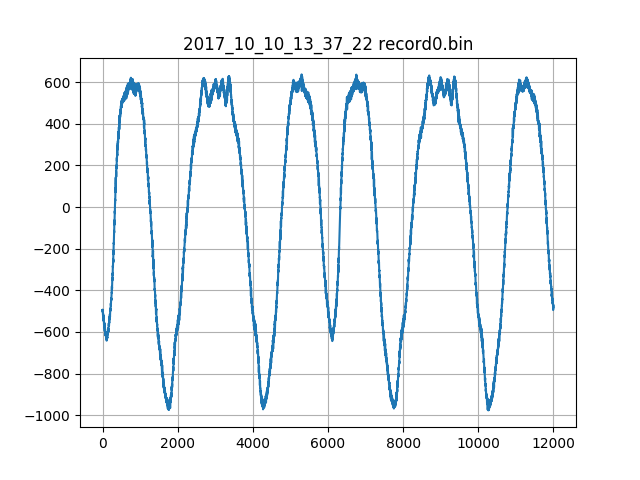

In [7]:
filename = data_dir + "/record0.bin"
readFile( filename, samplesPerFile, timeSerie_A, timeSerie_B )
plt.figure()
plt.plot( timeSerie_A[0:12000] )
plt.title("2017_10_10_13_37_22 record0.bin")
plt.grid()

### Rebuild the data files

In [ ]:
tmp_A = np.zeros( 3 * samplesPerFile )
tmp_B = np.zeros( 3 * samplesPerFile )

rebuilt_A = np.zeros( (nbFilesToRebuild, samplesPerFile) )
rebuilt_B = np.zeros( (nbFilesToRebuild, samplesPerFile) )

In [ ]:
readFile( data_dir + "/record0.bin", samplesPerFile,  timeSerie_A, timeSerie_B )
tmp_A[ 0 : samplesPerFile ] = timeSerie_A
tmp_B[ 0 : samplesPerFile ] = timeSerie_B

readFile( data_dir + "/record6.bin", samplesPerFile, timeSerie_A, timeSerie_B )
tmp_A[ samplesPerFile : 2 * samplesPerFile ] = timeSerie_A
tmp_B[ samplesPerFile : 2 * samplesPerFile ] = timeSerie_B
    
readFile( data_dir + "/record12.bin", samplesPerFile, timeSerie_A, timeSerie_B )
tmp_A[ 2 * samplesPerFile : 3 * samplesPerFile ] = timeSerie_A
tmp_B[ 2 * samplesPerFile : 3 * samplesPerFile ] = timeSerie_B
    
triggers = np.where( np.diff(tmp_B) > threshold )[0]
print("triggers {}".format(triggers[0]))

initialTrig = triggers[0] + 1
print("initialtrigger {}".format(initialTrig))

rebuilt_A[0, :] = tmp_A[ initialTrig : initialTrig + samplesPerFile ]
rebuilt_B[0, :] = tmp_B[ initialTrig : initialTrig + samplesPerFile ]
    
for k in range(2, nbFilesToRebuild):
    
    # read the data
    nb = str( int( k * blocksPerFile + firstFile) )
    filename = data_dir + "/record" + nb + ".bin"
    readFile( filename, samplesPerFile, timeSerie_A, timeSerie_B )
    
    # shift the data
    tmp_A[ 0 : samplesPerFile ] = tmp_A[ samplesPerFile : 2 * samplesPerFile ]
    tmp_A[ samplesPerFile : 2 * samplesPerFile ] = tmp_A[ 2 * samplesPerFile : 3 * samplesPerFile ]
    tmp_A[ 2 * samplesPerFile : 3 * samplesPerFile ] = timeSerie_A
    
    tmp_B[ 0 : samplesPerFile ] = tmp_B[ samplesPerFile : 2 * samplesPerFile ]
    tmp_B[ samplesPerFile : 2 * samplesPerFile ] = tmp_B[ 2 * samplesPerFile : 3 * samplesPerFile ]
    tmp_B[ 2 * samplesPerFile : 3 * samplesPerFile ] = timeSerie_B
    
    triggers = np.where( np.diff(tmp_B) > threshold )[0]
    
    trigOK = 0
    whichTrig = 0
    for trig in triggers:
        if trigOK == 0:
            if (tmp_B[trig+1] > threshold and tmp_B[trig+20] > threshold and tmp_B[trig+30] > threshold):
                # ok, this is a trigger, copy the data
                trigOK = 1
            else:
                # this was not a trigger, check the next trigger
                print("trigger dropped")
                whichTrig += 1
                pass
                
    if trigOK !=1:
        trig = 0
        print( "error, no trigger detected, current nb is {}, trigger set to {}".format(nb, trig) )
    else:
        trig = triggers[whichTrig] + 1
        print("k = {}, file = {}, triggers =  {}, selected trigger = {}".format(k, nb, triggers[0], trig))
    
    rebuilt_A[ k, : ] = tmp_A[ trig : trig + samplesPerFile ]
    rebuilt_B[ k, : ] = tmp_B[ trig : trig + samplesPerFile ]

In [ ]:
A_reshaped = rebuilt_A.reshape(nbFilesToRebuild * rampsPerFile, samplesPerRamp)
B_reshaped = rebuilt_B.reshape(nbFilesToRebuild * rampsPerFile, samplesPerRamp)

In [ ]:
coupling_A = np.average(A_reshaped, 0)
A_reshaped -= coupling_A

In [ ]:
plt.figure()
plt.plot(coupling_A)
plt.title("coupling 20 files 2017_10_10_13_37_22")
plt.grid()

In [ ]:
#A_reshaped += coupling_A

In [ ]:
ifft_a = np.fft.ifft( (A_reshaped[55000:65000,0:3000]), axis = 1 )

In [ ]:
plt.matshow( 20 * np.log10( np.abs( ifft_a[:,50:500] ) ), aspect='auto' )
plt.title("Track 1 / Flight over 1\nFiles {} to {}".format(firstFile, lastFile) )

In [ ]:
np.save(data_dir + '/samplesA_track1_flightover1.npy', A_reshaped)

In [ ]:
A_reshaped.shape

In [ ]:
plt.matshow( np.abs( ifft_a[:,50:250] ), aspect='auto' )
plt.title("Track 1 / Flight over 1\nFiles {} to {}".format(firstFile, lastFile) )

In [ ]:
plt.plot( 20 * np.log10( np.abs( ifft_a[10000,1:500] ) ) )